In [2]:
import json
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

asinToIndex = {}
index = 0
scoreMatrix = []
booksAsin = []
chunks = pd.read_json(
    '../Dataset/Books.json', lines=True, chunksize=100000, 
    typ="frame", orient="records", dtype={"asin": str, "overall": int}
)

for chunk in chunks:
    for _, item in chunk.iterrows():
        asin = item["asin"]
        rate = item["overall"]

        if (asin not in asinToIndex):
            scoreMatrix.append([0,0,0,0,0])
            booksAsin.append(asin)
            asinToIndex[asin] = index
            index += 1

        row = asinToIndex[asin]
        scoreMatrix[row][rate-1] += 1
    break # comment to load everything

scoreMatrix = np.array(scoreMatrix)
pdScoreMat = pd.DataFrame(
    data=scoreMatrix,
    index=booksAsin,
    columns=[f"{i} ⭐" for i in range(1, 6)]
)
pdScoreMat

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5
...,...,...,...,...,...
0060534095,0,0,0,1,4
0060534214,5,5,4,19,22
0060534249,2,2,5,12,17
0060534389,1,3,9,30,23


In [3]:
nbRating = np.sum(scoreMatrix, axis=1)
print(f"Nb rating = {nbRating}")
avgRatings = (np.average(scoreMatrix, axis=1, weights=[1,2,3,4,5]) * 15) / nbRating
print(f"Average rating = {avgRatings}")

stdRatings = np.std(scoreMatrix, axis=0)
print(f"Rating's standard deviation = {avgRatings}")

maxRating = np.max(scoreMatrix, axis=0)
minRating = np.min(scoreMatrix, axis=0)
print(f"Max rating = {maxRating}, Min Rating = {minRating}")

ratingQ1 = np.quantile(scoreMatrix, 0.25, axis=0)
ratingQ2 = np.quantile(scoreMatrix, 0.5, axis=0)
ratingQ3 = np.quantile(scoreMatrix, 0.75, axis=0)
print(f"Rating quantile : Q1 = {ratingQ1}, Q2 = {ratingQ2}, Q3 = {ratingQ3}")

Nb rating = [206  18  16 ...  38  66  29]
Average rating = [4.67475728 3.55555556 4.625      ... 4.05263158 4.07575758 4.27586207]
Rating's standard deviation = [4.67475728 3.55555556 4.625      ... 4.05263158 4.07575758 4.27586207]
Max rating = [ 593  450  644  846 2605], Min Rating = [0 0 0 0 0]
Rating quantile : Q1 = [0. 0. 0. 1. 3.], Q2 = [0. 0. 1. 3. 6.], Q3 = [ 1.  1.  3.  7. 14.]


In [4]:
# Books sorted by average score
sortedIndicies = np.flip(np.argsort(avgRatings)) # Ascending order
top3Books = [booksAsin[i] for i in sortedIndicies[0:3]]
bottom3Books = [booksAsin[i] for i in sortedIndicies[-1:-4:-1]]
print(f"Top 3 books : {top3Books}, Bottom 3 books : {bottom3Books}")
q1BestBooksAsins = [booksAsin[i] for i in sortedIndicies[0:math.ceil(len(sortedIndicies) * 0.25)]]
print(f"First Quantile of Best books : {q1BestBooksAsins}")

Top 3 books : ['0060011076', '0006151329', '0060267879'], Bottom 3 books : ['006000455X', '006052846X', '0028642600']
First Quantile of Best books : ['0060011076', '0006151329', '0060267879', '0060267887', '0060107790', '0060089113', '0060089083', '0028643909', '0060269952', '0025174304', '0006481353', '0060514485', '002520260X', '0007160003', '0007156790', '0060153180', '0002250357', '0060193042', '0006513778', '0007268939', '0060087390', '0060105518', '0007192932', '0060511141', '0060220732', '0007222017', '0029166837', '006023640X', '006050871X', '0007232616', '0029174317', '0060232196', '000617681X', '0029216052', '0060265051', '002907990X', '0029079373', '0004723023', '0029077354', '0060257016', '0007202474', '0030007380', '006009110X', '0027083314', '006015649X', '0060156783', '0028609891', '0028640004', '0027651908', '0060532459', '0060532467', '0028639197', '0060186275', '0007339615', '0060174021', '0060519150', '0027436284', '0028629051', '0007111444', '0028627377', '006001182

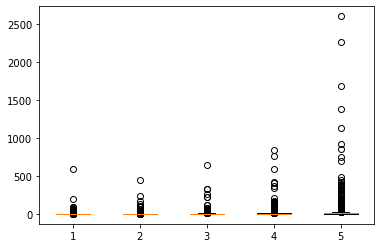

In [5]:
plt.boxplot(scoreMatrix)
plt.show()

Eigenvector : [4.19065077 0.65182353 0.11502149 0.03191829 0.01247986]
Eigenvalues : [[-0.43000607 -0.53147085 -0.5420341  -0.48734244  0.03646789]
 [-0.46592004 -0.33196711  0.09245368  0.70135923  0.41504687]
 [-0.48128217 -0.09377765  0.37507236  0.05101855 -0.78504207]
 [-0.46055629  0.33554744  0.49608976 -0.4777811   0.44823654]
 [-0.39277052  0.69710132 -0.55755451  0.19928598 -0.09591216]]
Seperation percentages of PCs : [83.78128013773434, 13.031534376530264, 2.2995588234814344, 0.6381240165067785, 0.24950264574715997]


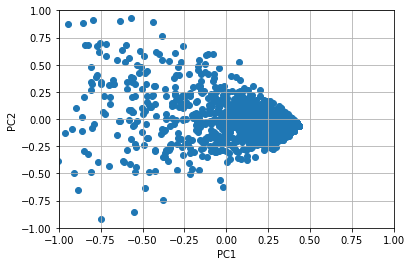

In [31]:
# Calculating PCA
normalizedScoreMatrix = (scoreMatrix - np.mean(scoreMatrix, axis = 0)) / np.std(scoreMatrix, axis = 0)
# normalizedScoreMatrix -= np.mean(scoreMatrix, axis = 0)  
scoreMatrixCov = np.cov(normalizedScoreMatrix, rowvar = False) # rowvar allows us to transpose data!
eigenValues, eigenVectors = np.linalg.eig(scoreMatrixCov)
print(f"Eigenvector : {eigenValues}")
print(f"Eigenvalues : {eigenVectors}")

idx = np.argsort(eigenValues)[::-1]
evecs = eigenVectors[:,idx]
evals = eigenValues[idx]

# Variance of each Principal Component (PC)
evalsSum = sum(evals)
evalsVar = [ (eval/sum(evals))*100 for eval in evals ]
print(f"Seperation percentages of PCs : {evalsVar}")

#  PCA calculation and plotting
projectionMatrix = np.transpose(np.transpose(evecs)[:][:2])
scoreMatrixPCA = np.dot(normalizedScoreMatrix, projectionMatrix)

# Calculate better average metric to classify books
bayesAvgRatings = (np.average(scoreMatrix, axis=1, weights=[1,2,3,4,5]) * 15) / nbRating
print(f"Average rating = {avgRatings}")

x, y = np.transpose(scoreMatrixPCA)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
plt.scatter(x, y)
plt.show()